In [1]:
from collections import defaultdict
from itertools import product
from copy import deepcopy
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import pandas as pd
import seaborn as sns
import scipy.stats as spst
import sklearn.metrics as skm
import sklearn.utils as skut
import sklearn.preprocessing as skpp
import time
import warnings

from sklearn.manifold import TSNE

import condo

from tabpfn import TabPFNClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.cluster import KMeans

In [2]:
datapath = "/Users/calvinm/sandbox/condo-adapter/data"
maledata = pd.read_csv(f"{datapath}/ANSUR_II_male_Public.csv", encoding='latin-1', index_col='subjectid')
femaledata = pd.read_csv(f"{datapath}/ANSUR_II_female_Public.csv", encoding='latin-1', index_col='SubjectId')
meta_columns = [
    'Gender', 'Date', 'Installation', 'Component', 'Branch', 'PrimaryMOS', 'SubjectsBirthLocation',
    'SubjectNumericRace', 'Ethnicity', 'DODRace', 'Age', 'Heightin', 'Weightlbs', 'WritingPreference'
]
feature_columns = [col for col in list(maledata.columns) if col not in meta_columns]
d = len(feature_columns)
n_random = 10
male_samples = 500
female_samples = 500
predvar = 'Gender'
predPosVal = 'Male'
predNegVal = 'Female'
confoundervar = 'Gender'
othervar = 'isHeightGT56'
transform_type = 'affine'
posFracSrc = 0.75
negFracSrc = 0.25
notargetshift = ''
nofeatureshift = ''
#nofeatureshift = 'nofeatureshift'
#notargetshift = 'notargetshift'
if notargetshift == 'notargetshift':
    posFracSrc = 0.5
    negFracSrc = 0.5

In [3]:
metrics_dict = {
    'Accuracy (Gender)': [],
    'Accuracy (Height > 5ft6in)': [],
    'rMSE': [],
    'rMSEs': [],
    'rel-rMSEs': [],
}
methods = [
    'Source',
    'Target (pre-feature shift)',
    'Target (post-feature shift)',
    'Gaussian OT',
    'MMD',
    'ConDo Gaussian KLD',
    'ConDo MMD',
]
minfos = [
    ('Gaussian OT', partial(condo.AdapterGaussianOT, transform_type=transform_type)), 
    ('MMD', partial(condo.AdapterMMD, transform_type=transform_type, mmd_size=20, verbose=0)),
    ('ConDo Gaussian KLD', partial(condo.ConDoAdapterKLD, transform_type=transform_type)),
    ('ConDo MMD', partial(condo.ConDoAdapterMMD, transform_type=transform_type, mmd_size=20, verbose=0)),
]
results_dict = {mname: deepcopy(metrics_dict) for mname in methods}
for rix in range(n_random):
    rng = skut.check_random_state(rix)
    male_ixs = rng.choice(maledata.shape[0], size=male_samples, replace=False)
    female_ixs = rng.choice(femaledata.shape[0], size=female_samples, replace=False)
    data = pd.concat([maledata.iloc[male_ixs, :], femaledata.iloc[female_ixs, :]], axis=0)
    data[feature_columns] = skpp.StandardScaler().fit_transform(data[feature_columns])
    X = data[feature_columns].astype(np.float64)
    X_ = X.values
    Meta = data[meta_columns]
    Meta['isHeightGT56'] = (Meta['Heightin'] > 66).astype(str)
    Meta_ = Meta.values

    PosIxs, = (Meta[predvar].values == predPosVal).nonzero()
    NegIxs, = (Meta[predvar].values == predNegVal).nonzero()
    rng.shuffle(PosIxs)
    rng.shuffle(NegIxs)
    nPosSrc = int(posFracSrc*PosIxs.size)
    nNegSrc = int(negFracSrc*NegIxs.size)
    SrcIxs = np.concatenate([PosIxs[:nPosSrc], NegIxs[:nNegSrc]])
    TgtIxs = np.concatenate([PosIxs[nPosSrc:], NegIxs[nNegSrc:]])
    rng.shuffle(SrcIxs)
    rng.shuffle(TgtIxs)
    SrcX_ = X_[SrcIxs, :]
    TgtX_ = X_[TgtIxs, :]
    SrcY_ = Meta[predvar].values[SrcIxs]
    TgtY_ = Meta[predvar].values[TgtIxs]
    SrcZ_ = Meta[confoundervar].values[SrcIxs]
    TgtZ_ = Meta[confoundervar].values[TgtIxs]

    if transform_type == 'affine':
        A = (
            spst.ortho_group(d, seed=rng).rvs()
            @ np.diag(rng.uniform(0.5, 2., size=d))
            @ spst.ortho_group(d, seed=rng).rvs()
        )
        b = np.zeros((1, d))
    elif transform_type == 'location-scale':
        A = np.diag(rng.uniform(0.5, 2., size=d))
        b = rng.uniform(0.5, 2., size=d)
    if nofeatureshift == 'nofeatureshift':
        A = np.eye(d)
        b = np.zeros((1, d))
    modTgtX_ = TgtX_ @ A + b

    clf = TabPFNClassifier()
    clf.fit(SrcX_, SrcY_)
    clfOther = TabPFNClassifier()
    clfOther.fit(SrcX_, Meta[othervar].values[SrcIxs])
    
    clf_src_pred = clf.predict(SrcX_)
    clfOther_src_pred = clfOther.predict(SrcX_)
    clf_src_acc = accuracy_score(SrcY_, clf_src_pred)
    clfOther_src_acc = accuracy_score(Meta[othervar].values[SrcIxs], clfOther_src_pred)
    results_dict['Source']['Accuracy (Gender)'].append(clf_src_acc)
    results_dict['Source']['Accuracy (Height > 5ft6in)'].append(clfOther_src_acc)
    
    clf_tgt_pred = clf.predict(TgtX_)
    clfOther_tgt_pred = clfOther.predict(TgtX_)
    clf_tgt_acc = accuracy_score(TgtY_, clf_tgt_pred)
    clfOther_tgt_acc = accuracy_score(Meta[othervar].values[TgtIxs], clfOther_tgt_pred)
    results_dict['Target (pre-feature shift)']['Accuracy (Gender)'].append(clf_tgt_acc)
    results_dict['Target (pre-feature shift)']['Accuracy (Height > 5ft6in)'].append(clfOther_tgt_acc)

    clf_modtgt_pred = clf.predict(modTgtX_)
    clfOther_modtgt_pred = clfOther.predict(modTgtX_)
    clf_modtgt_acc = accuracy_score(TgtY_, clf_modtgt_pred)
    clfOther_modtgt_acc = accuracy_score(Meta[othervar].values[TgtIxs], clfOther_modtgt_pred)
    results_dict['Target (post-feature shift)']['Accuracy (Gender)'].append(clf_modtgt_acc)   
    results_dict['Target (post-feature shift)']['Accuracy (Height > 5ft6in)'].append(clfOther_modtgt_acc)   
    results_dict['Target (post-feature shift)']['rMSE'].append(
        np.sqrt(np.mean( (modTgtX_ - TgtX_) ** 2 ))
    )

    for mname, mfunc in minfos:
        adapter = mfunc()
        if 'ConDo' in mname:
            adapter.fit(modTgtX_, SrcX_, TgtZ_.astype(str).reshape(-1, 1), SrcZ_.astype(str).reshape(-1, 1))
        else:
            adapter.fit(modTgtX_, SrcX_)
        adaptModTgtX_ = adapter.transform(modTgtX_)    
        clf_adaptmodtgt_pred = clf.predict(adaptModTgtX_)
        clfOther_adaptmodtgt_pred = clfOther.predict(adaptModTgtX_)
        clf_adaptmodtgt_acc = accuracy_score(TgtY_, clf_adaptmodtgt_pred)
        clfOther_adaptmodtgt_acc = accuracy_score(Meta[othervar].values[TgtIxs], clfOther_adaptmodtgt_pred)
        results_dict[mname]['Accuracy (Gender)'].append(clf_adaptmodtgt_acc)
        results_dict[mname]['Accuracy (Height > 5ft6in)'].append(clfOther_adaptmodtgt_acc)
        results_dict[mname]['rMSE'].append(
            np.sqrt(np.mean( (adaptModTgtX_ - TgtX_) ** 2 ))
        )
        results_dict[mname]['rel-rMSEs'].append(
            np.mean( (adaptModTgtX_ - TgtX_) ** 2 , axis=0) / np.mean( (modTgtX_ - TgtX_) ** 2 , axis=0)
        )
        results_dict[mname]['rMSEs'].append(
            np.mean( (adaptModTgtX_ - TgtX_) ** 2 , axis=0)
        )

/var/folders/v4/3xrgrxhn7djdts76_v6vkfjc0000gn/T/ipykernel_40423/3100947209.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Meta['isHeightGT56'] = (Meta['Heightin'] > 66).astype(str)
/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/che

         Current function value: 382.307501
         Iterations: 10
         Function evaluations: 11


/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/m

         Current function value: 382.052310
         Iterations: 10
         Function evaluations: 11


/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/m

         Current function value: 377.014481
         Iterations: 10
         Function evaluations: 11


/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/m

         Current function value: 393.380312
         Iterations: 10
         Function evaluations: 11


/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/m

         Current function value: 372.420061
         Iterations: 10
         Function evaluations: 11


/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/m

         Current function value: 373.881484
         Iterations: 10
         Function evaluations: 11


/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/m

         Current function value: 398.138762
         Iterations: 10
         Function evaluations: 11


/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/m

         Current function value: 386.481917
         Iterations: 10
         Function evaluations: 11


/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/m

         Current function value: 394.430258
         Iterations: 10
         Function evaluations: 11


/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/m

         Current function value: 405.338464
         Iterations: 10
         Function evaluations: 11


/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/m

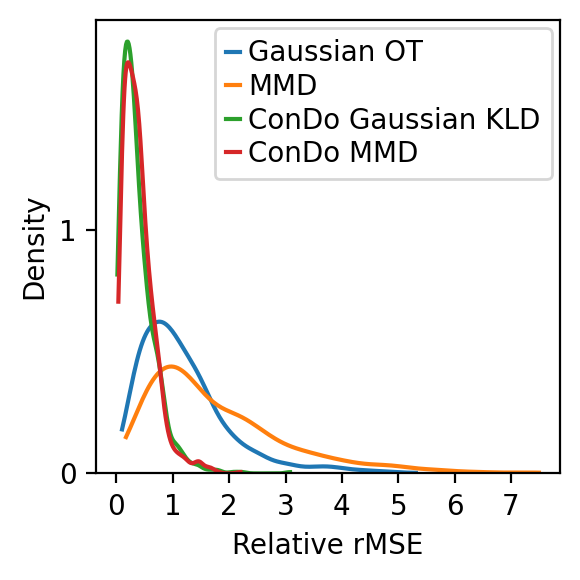

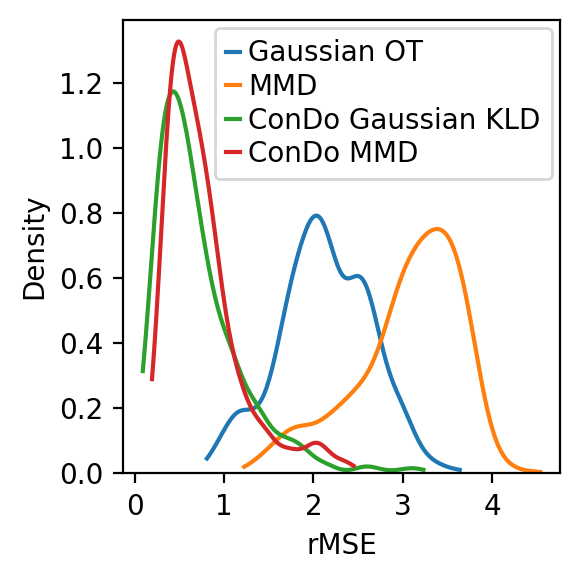

In [4]:
plt.figure(figsize=(3, 3), dpi=200)
for mname, _ in minfos:
    sns.kdeplot(np.concatenate(results_dict[mname]['rel-rMSEs']), cut=0, label=mname);
plt.legend(labelspacing=0.2, handlelength=0.5, handletextpad=0.3, borderaxespad=0.3);
plt.ylabel('Density');
plt.yticks([0, 1]);
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7]);
plt.xlabel('Relative rMSE');
plt.tight_layout();
plt.savefig(f'ansur-{transform_type}{nofeatureshift}{notargetshift}-gender-relrMSE.png');

plt.figure(figsize=(3, 3), dpi=200)
for mname, _ in minfos:
    sns.kdeplot(np.concatenate(results_dict[mname]['rMSEs']), cut=0, label=mname);
plt.legend(labelspacing=0.2, handlelength=0.5, handletextpad=0.3, borderaxespad=0.3);
plt.ylabel('Density');
#plt.yticks([0, 1]);
#plt.xticks([0, 1, 2, 3, 4, 5, 6, 7]);
plt.xlabel('rMSE');
plt.tight_layout();
plt.savefig(f'ansur-{transform_type}{nofeatureshift}{notargetshift}-gender-rMSE.png');

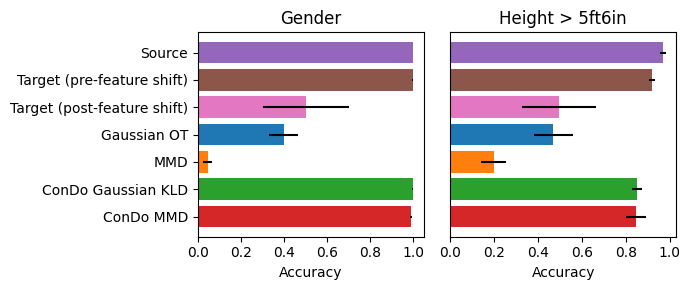

In [5]:
fig, axes = plt.subplots(figsize=(7,3), ncols=2);
#for mix, mname in enumerate(methods):
for mix, mname in zip([3,4,5,6, 0, 1, 2], methods[3:] + methods[0:3]):
    axes[0].barh(
        mix,
        np.array(results_dict[mname]['Accuracy (Gender)']).mean(),
        xerr=np.array(results_dict[mname]['Accuracy (Gender)']).std(),
        label=mname, alpha=1,
    );
axes[0].set_yticks([3,4,5,6, 0, 1, 2], labels=methods[3:] + methods[0:3])
#axes[0].set_yticks(range(len(methods)), methods);
axes[0].invert_yaxis()
axes[0].set_title('Gender');
axes[0].set_xlabel('Accuracy');
axes[0].set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]); 

#for mix, mname in enumerate(methods):
for mix, mname in zip([3,4,5,6, 0, 1, 2], methods[3:] + methods[0:3]):
    axes[1].barh(
        mix,
        np.array(results_dict[mname]['Accuracy (Height > 5ft6in)']).mean(),
        xerr=np.array(results_dict[mname]['Accuracy (Height > 5ft6in)']).std(),
        label=mname, alpha=1,
    );
axes[1].set_yticks([]);
axes[1].invert_yaxis()
axes[1].set_title('Height > 5ft6in');
axes[1].set_xlabel('Accuracy');
axes[1].set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]); 

plt.tight_layout();
plt.savefig(f'ansur-{transform_type}{nofeatureshift}{notargetshift}-gender-accuracy.pdf');

In [6]:
with open(f"ansur-{transform_type}{nofeatureshift}{notargetshift}-gender-rmse.txt", "w") as f:
    f.write("method mean std\n")
    for mname in methods:
        f.write(f"{mname} {np.mean(results_dict[mname]['rMSE'])} {np.std(results_dict[mname]['rMSE'])}\n")
        print(f"{mname} {np.mean(results_dict[mname]['rMSE'])} {np.std(results_dict[mname]['rMSE'])}")

Source nan nan
Target (pre-feature shift) nan nan
Target (post-feature shift) 1.6368533284477054 0.0486448903908276
Gaussian OT 1.4513939429197613 0.142632236323168
MMD 1.7466593049039933 0.04863111260301864
ConDo Gaussian KLD 0.841109390320082 0.10275558011052179
ConDo MMD 0.8672513767380734 0.0947194406053306


/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [7]:
metrics_dict = {
    'Accuracy (Gender)': [],
    'Accuracy (Height > 5ft6in)': [],
}
methods = [
    'Gaussian OT',
    'MMD',
    'ConDo Gaussian KLD',
    'ConDo MMD',
]
minfos = [
    ('Gaussian OT', partial(condo.AdapterGaussianOT, transform_type=transform_type)), 
    ('MMD', partial(condo.AdapterMMD, transform_type=transform_type, mmd_size=20, verbose=0)),
    ('ConDo Gaussian KLD', partial(condo.ConDoAdapterKLD, transform_type=transform_type)),
    ('ConDo MMD', partial(condo.ConDoAdapterMMD, transform_type=transform_type, mmd_size=20, verbose=0)),
]
results2_dict = {mname: deepcopy(metrics_dict) for mname in methods}
for rix in range(n_random):
    rng = skut.check_random_state(rix)
    male_ixs = rng.choice(maledata.shape[0], size=male_samples, replace=False)
    female_ixs = rng.choice(femaledata.shape[0], size=female_samples, replace=False)
    data = pd.concat([maledata.iloc[male_ixs, :], femaledata.iloc[female_ixs, :]], axis=0)
    data[feature_columns] = skpp.StandardScaler().fit_transform(data[feature_columns])
    X = data[feature_columns].astype(np.float64)
    X_ = X.values
    Meta = data[meta_columns]
    Meta['isHeightGT56'] = (Meta['Heightin'] > 66).astype(str)
    Meta_ = Meta.values

    PosIxs, = (Meta[predvar].values == predPosVal).nonzero()
    NegIxs, = (Meta[predvar].values == predNegVal).nonzero()
    rng.shuffle(PosIxs)
    rng.shuffle(NegIxs)
    nPosSrc = int(posFracSrc*PosIxs.size)
    nNegSrc = int(negFracSrc*NegIxs.size)
    SrcIxs = np.concatenate([PosIxs[:nPosSrc], NegIxs[:nNegSrc]])
    TgtIxs = np.concatenate([PosIxs[nPosSrc:], NegIxs[nNegSrc:]])
    rng.shuffle(SrcIxs)
    rng.shuffle(TgtIxs)
    SrcX_ = X_[SrcIxs, :]
    TgtX_ = X_[TgtIxs, :]
    SrcY_ = Meta[predvar].values[SrcIxs]
    TgtY_ = Meta[predvar].values[TgtIxs]
    SrcZ_ = Meta[confoundervar].values[SrcIxs]
    TgtZ_ = Meta[confoundervar].values[TgtIxs]

    if transform_type == 'affine':
        A = (
            spst.ortho_group(d, seed=rng).rvs()
            @ np.diag(rng.uniform(0.5, 2., size=d))
            @ spst.ortho_group(d, seed=rng).rvs()
        )
        b = np.zeros((1, d))
    elif transform_type == 'location-scale':
        A = np.diag(rng.uniform(0.5, 2., size=d))
        b = rng.uniform(0.5, 2., size=d)
    if nofeatureshift == 'nofeatureshift':
        A = np.eye(d)
        b = np.zeros((1, d))
    modTgtX_ = TgtX_ @ A + b
   
    for mname, mfunc in minfos:
        adapter = mfunc()
        if 'ConDo' in mname:
            adapter.fit(SrcX_, modTgtX_, SrcZ_.astype(str).reshape(-1, 1), TgtZ_.astype(str).reshape(-1, 1))
        else:
            adapter.fit(SrcX_, modTgtX_)
        adaptSrcX_ = adapter.transform(SrcX_)    

        clf = TabPFNClassifier()
        clf.fit(adaptSrcX_, SrcY_)
        clfOther = TabPFNClassifier()
        clfOther.fit(adaptSrcX_, Meta[othervar].values[SrcIxs])
        
        clf_modtgt_pred = clf.predict(modTgtX_)
        clfOther_modtgt_pred = clfOther.predict(modTgtX_)
        clf_modtgt_acc = accuracy_score(TgtY_, clf_modtgt_pred)
        clfOther_modtgt_acc = accuracy_score(Meta[othervar].values[TgtIxs], clfOther_modtgt_pred)
        results2_dict[mname]['Accuracy (Gender)'].append(clf_modtgt_acc)
        results2_dict[mname]['Accuracy (Height > 5ft6in)'].append(clfOther_modtgt_acc)

/var/folders/v4/3xrgrxhn7djdts76_v6vkfjc0000gn/T/ipykernel_40423/1198598054.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Meta['isHeightGT56'] = (Meta['Heightin'] > 66).astype(str)
/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/che

         Current function value: 359.291706
         Iterations: 10
         Function evaluations: 11


/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/m

         Current function value: 398.585795
         Iterations: 10
         Function evaluations: 11


/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/m

         Current function value: 348.934014
         Iterations: 10
         Function evaluations: 11


/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/m

         Current function value: 358.436737
         Iterations: 10
         Function evaluations: 11


/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/m

         Current function value: 417.958329
         Iterations: 10
         Function evaluations: 11


/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/m

         Current function value: 346.742131
         Iterations: 10
         Function evaluations: 11


/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/m

         Current function value: 346.168895
         Iterations: 10
         Function evaluations: 11


/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/m

         Current function value: 349.173605
         Iterations: 10
         Function evaluations: 11


/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/m

         Current function value: 450.493400
         Iterations: 10
         Function evaluations: 11


/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/m

         Current function value: 361.994370
         Iterations: 10
         Function evaluations: 11


/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/micecondo/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/calvinm/miniconda3/envs/m

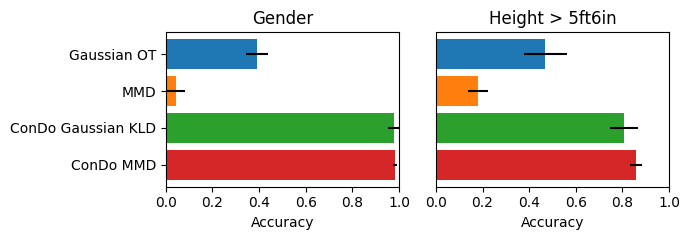

In [8]:
fig, axes = plt.subplots(figsize=(7,2.5), ncols=2);
for mix, mname in enumerate(methods):
    axes[0].barh(
        mix,
        np.array(results2_dict[mname]['Accuracy (Gender)']).mean(),
        xerr=np.array(results2_dict[mname]['Accuracy (Gender)']).std(),
        label=mname, alpha=1,
    );
axes[0].set_xlim(0, 1);
axes[0].set_yticks(range(len(methods)), methods);
axes[0].set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]); 
axes[0].invert_yaxis()
axes[0].set_title('Gender');
axes[0].set_xlabel('Accuracy');

for mix, mname in enumerate(methods):
    axes[1].barh(
        mix,
        np.array(results2_dict[mname]['Accuracy (Height > 5ft6in)']).mean(),
        xerr=np.array(results2_dict[mname]['Accuracy (Height > 5ft6in)']).std(),
        label=mname, alpha=1,
    );
axes[1].set_xlim(0, 1);
axes[1].set_yticks([]);
axes[1].invert_yaxis();
axes[1].set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]); 
axes[1].set_title('Height > 5ft6in');
axes[1].set_xlabel('Accuracy');

plt.tight_layout();
plt.savefig(f'ansur-{transform_type}{nofeatureshift}{notargetshift}-gender-accuracy-OnAdapted.pdf');